# CNN Data Augmentation and Preprocessing

*Compiled by: Christopher Monterola* </br>
*Organized by: Christopher Monterola and Michael Dorosan*

Lecture is taken from:

**1. Python Machine Learning, Second Edition, Sebastian Raschka and Vahid Mirjalili, Packt Publishing Ltd. Birmingham B3 2PB, UK Sept 2017.**

**2. Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurélien Géron, O'Reilly 2017.**

**3. Deep Learning with Python, Francois Chollet, Manning New York 2018.**

Here we consider one example and in the process demonstrates how one can improve the accuracy (avoid overfitting) by data augmentation using keras.

# Example  5. Cats vs Dogs Data Set (Kaggle 2013)

The Dogs vs. Cats dataset that you’ll use isn’t packaged with Keras. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when CNN weren’t mainstream. You can download the original dataset from www.kaggle.com/c/dogs-vs-cats/data (you’ll need to create a Kaggle account if you don’t already
have one).

The pictures are medium-resolution color JPEGs. Figure below shows some examples.

<img src="images/cats_vs_dogs_samples.jpg" width="700">

Unsurprisingly, the dogs-versus-cats Kaggle competition in 2013 was won by entrants who used CNN. The best entries achieved up to 95% accuracy. In this example, you can get up to $83\%$ accuracy for test set even though you’ll train your models on less than 10% of the data that was available to the competitors.

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing it, you’ll create a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 500 samples of each class.

###  Copying images to training, validation, and test directories

The following copies images from the downloaded training dataset `train.zip` into useable `train`, `validation`, and `test` sets. This was done using the `create_dataset` function. Readers of Chollet will easily recognize that this is a shortened version of the code presented in the book. 

In [1]:
import os, shutil

In [2]:
# this function can be used to copy images to train, validation, and test dirs
def create_dataset(src, dst, range_, class_):
    """Copy images of class class_ within range_ from src to dst.
    
    Parameters
    ----------
    src : str
        source directory
    dst : str
        destination directory
    range_ : tuple
        tuple of min and max image index to copy
    class_ : str
        image class (e.g., 'cat' or 'dog')
    """
    if os.path.exists(dst):
        # if existing, delete dir to reset
        shutil.rmtree(dst)
    os.makedirs(dst)
    fnames = [f'{class_}.{i}.jpg' for i in range(*range_)]
    for fname in fnames:
        src_file = os.path.join(src, fname)
        dst_file = os.path.join(dst, fname)
        shutil.copyfile(src_file, dst_file)

In [3]:
# looping through create_dataset for each class
classes = ['dog', 'cat']
for class_ in classes:
    src = 'dogs_vs_cats' # source file
    
    dst = f'train/{class_}' # train
    create_dataset(src, dst, range_=(0, 1000), class_=class_)

    dst = f'validation/{class_}' # val
    create_dataset(src, dst, range_=(1000, 1500), class_=class_)
    
    dst = f'test/{class_}' # test
    create_dataset(src, dst, range_=(1500, 2000), class_=class_)

FileNotFoundError: [Errno 2] No such file or directory: 'dogs_vs_cats/dog.0.jpg'

In [34]:
train_dogs_dir = 'train/dog'
train_cats_dir =  'train/cat'
validation_dogs_dir = 'validation/dog'
validation_cats_dir = 'validation/cat'
test_dogs_dir = 'test/dog'
test_cats_dir = 'test/cat'

**Check the number of files**

In [35]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


So you do indeed have 2,000 training images, 1000 validation images, and 1000 test images accounting both classes. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means *classification accuracy* will be an appropriate measure of success.

# Building your network

You built a small CNN for MNIST in the previous example, so you should be familiar with such CNN. You’ll reuse the same general structure: the CNN will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers. But because you’re dealing with bigger images and a more complex problem (previously we used MNIST with $28 \times 28$ size and single channel), you’ll make your network larger, accordingly: it will have one more Conv2D + MaxPooling2D stage. This serves both to augment the capacity of the network and to further reduce the size of the feature maps so they aren’t overly large when you reach the Flatten layer. Here, because you start from inputs of size 150 × 150 (a somewhat arbitrary choice), you end up with feature maps of size 7 × 7 just before the Flatten layer.

**NOTE: The depth of the feature maps progressively increases in the network (from 32 to 128), whereas the size of the feature maps decreases (from 148 × 148 to 7 × 7). This is a pattern you’ll see in almost all CNN. Because you’re attacking a binary-classification problem, you’ll end the network with a single unit (a Dense layer of size 1) and a threshold function (we will be using sigmoid activation). This unit will encode the probability that the network is looking at one class or the other.**

# Instantiating a small CNN for dogs vs. cats classification

In [36]:
# this enables the other keras imports to be from tensorflow.keras
from tensorflow import keras

from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let’s look at how the dimensions of the feature maps change with every successive layer:

In [37]:
 model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)      

For the compilation step, you’ll go with the RMSprop optimizer, as usual. Because you
ended the network with a single sigmoid unit, you’ll use binary crossentropy as the
loss (as a reminder, check out table in [02_CNN_Fundamentals.ipynb](../02_CNN_Fundamentals/02_CNN_Fundamentals.ipynb) for a cheatsheet on what loss function to use in
various situations).

## Configuring the model for training

In [38]:
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(learning_rate=1e-4),
metrics=['acc'])

# Data preprocessing

As you know by now, data should be formatted into appropriately preprocessed floating point tensors before being fed into the network. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the network are roughly as follows:

1 Read the picture files.   
2 Decode the JPEG content to RGB grids of pixels.   
3 Convert these into floating-point tensors.   
4 Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).    


It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. Keras has a module with image-processing helper tools, located at keras.preprocessing.image. In particular, it contains the class ImageDataGenerator, which lets you quickly set up Python generators that can automatically turn image files on disk into batches of preprocessed tensors. This is what you’ll use here.

## Using ImageDataGenerator to read images from directories

<img src="images/keras_preprocessing.png" width="700">


In [39]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_dir = 'train'
validation_dir = 'validation'

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=20,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let’s look at the output of one of these generators: it yields batches of 150 × 150 RGB images (shape (20, 150, 150, 3)) and binary labels (shape (20,)). There are 20 samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, you need to break the iteration loop at some point: 
    

In [40]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


# Fitting the model using a batch generator

Let’s fit the model to the data using the generator. You do so using the `fit` method. In the recent past `fit_generator` was used when data generators are used for data inputs, however, this will be depracated and the same functionality is now integrated on the usual `fit`. 

The first argument is a `Python` generator that will yield batches of inputs and targets indefinitely, like this one does. Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator—that is, after having run for `steps_per_epoch` gradient descent steps—the fitting process will go to the next epoch. In this case, batches are `batch_size=20` samples, so it will take 100 batches until you see your target of 2,000 samples.    

When using `fit`--or formerly, `fit_generator`--you can also pass a `validation_data` argument. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of `Numpy` arrays. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [41]:
%%time
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 22s 204ms/step - loss: 0.6905 - acc: 0.5360 - val_loss: 0.6725 - val_acc: 0.5560
Epoch 2/30
100/100 [==============================] - 20s 201ms/step - loss: 0.6599 - acc: 0.5950 - val_loss: 0.6836 - val_acc: 0.5640
Epoch 3/30
100/100 [==============================] - 20s 198ms/step - loss: 0.6212 - acc: 0.6490 - val_loss: 0.6328 - val_acc: 0.6380
Epoch 4/30
100/100 [==============================] - 20s 199ms/step - loss: 0.5684 - acc: 0.7020 - val_loss: 0.5928 - val_acc: 0.6920
Epoch 5/30
100/100 [==============================] - 20s 200ms/step - loss: 0.5404 - acc: 0.7255 - val_loss: 0.5872 - val_acc: 0.6800
Epoch 6/30
100/100 [==============================] - 20s 199ms/step - loss: 0.5121 - acc: 0.7450 - val_loss: 0.6685 - val_acc: 0.6560
Epoch 7/30
100/100 [==============================] - 20s 197ms/step - loss: 0.4893 - acc: 0.7485 - val_loss: 0.5618 - val_acc: 0.7220
Epoch 8/30
100/100 [==============================] - 2

# Saving the model

It’s good practice to always save your models after training.

In [42]:
import pickle
# save model
model.save('./models/cats_and_dogs_prelim.h5')

# save history
with open('./models/cats_and_dogs_prelim_hist.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Let’s plot the loss and accuracy of the model over the training and validation data during training 

# Displaying curves of loss and accuracy during training

We now view the fitting history of our model. Specifically, we compare training and validation accuracy as a function of the fitting epochs. We also look at the training and validation loss.

Plotting the history provides an easier interpretation of a possible overfitting on the training set. Let's see if that is the case for the recently fitted (preliminary) model.

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hist(hist):
    """Plot fitting history, specifically accuracy and loss."""
    sns.set_style('darkgrid')
    _, ax = plt.subplots(1, 2, figsize=(12, 5))
    temp_df = pd.DataFrame(hist)
    temp_df = temp_df.reset_index()
    temp_df.plot(
        x='index', y='val_acc', label='Validation Accuracy', ax=ax[0], 
        c='tab:green', style='--'
    )
    temp_df.plot.scatter(
        x='index', y='acc', label='Training Accuracy', ax=ax[0], c='tab:green'
    )

    ax[0].set_ylabel('Accuracy', fontsize=15)
    ax[0].set_xlabel('Epochs', fontsize=15)
    
    temp_df.plot(
        x='index', y='val_loss', label='Validation Loss', ax=ax[1], 
        c='tab:orange', style='--'
    )
    temp_df.plot.scatter(
        x='index', y='loss', label='Training Loss', ax=ax[1], c='tab:orange'
    )

    ax[1].set_ylabel('Loss', fontsize=15)
    ax[1].set_xlabel('Epochs', fontsize=15)
    
    plt.suptitle('Fitting History Plots', fontsize=20)
    plt.tight_layout()

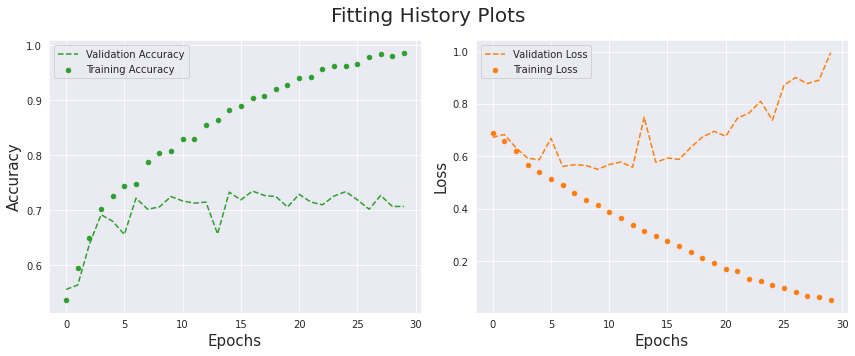

In [62]:
import pickle
with open('./models/cats_and_dogs_prelim_hist.pickle', 'rb') as handle:
    hist = pickle.load(handle)
    
plot_hist(hist)

These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy stalls at 70–72%. The validation loss reaches its minimum after only five epochs and then stalls, whereas the training loss keeps decreasing linearly until it reaches nearly 0. Because you have relatively few training samples (2,000), overfitting will be your number-one concern. You already know about a number of techniques that can help mitigate overfitting such as L2 regularization (or weight decay). Another way is dropout or forced pruning of weights. We’re now going to work below with a new one, specific to computer vision and used almost universally when processing images with deep-learning models: data augmentation. This is very important when you have limited data for images!

# Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better. In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ImageDataGenerator instance. Let’s get started with an example.

# Setting up a data augmentation configuration via ImageDataGenerator

These are just a few of the options available (for more, see the Keras documentation).

Let’s quickly go over this code:
        
* `rotation_range` is a value in degrees, a range within which to randomly rotate pictures.   

* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
        
* `shear_range` is for randomly applying shearing transformations.   
        
* `zoom_range` is for randomly zooming inside pictures.    
        
* `horizontal_flip` is for randomly flipping half the images horizontally—relevant when there are no   assumptions of horizontal asymmetry (for example, real-world pictures).    
        
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift. Default is 'nearest' but can be any of the following: *'constant'*, *'reflect'* or *'wrap'*. 

In [45]:
# sample augmented data generator
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Displaying some randomly augmented training images
Let’s look at the augmented images (*see below*). First, the **cheat sheet**:

<img src="images/augmentation1.png" width="700">

<img src="images/augmentation2.png" width="700">

### Actual Implementation

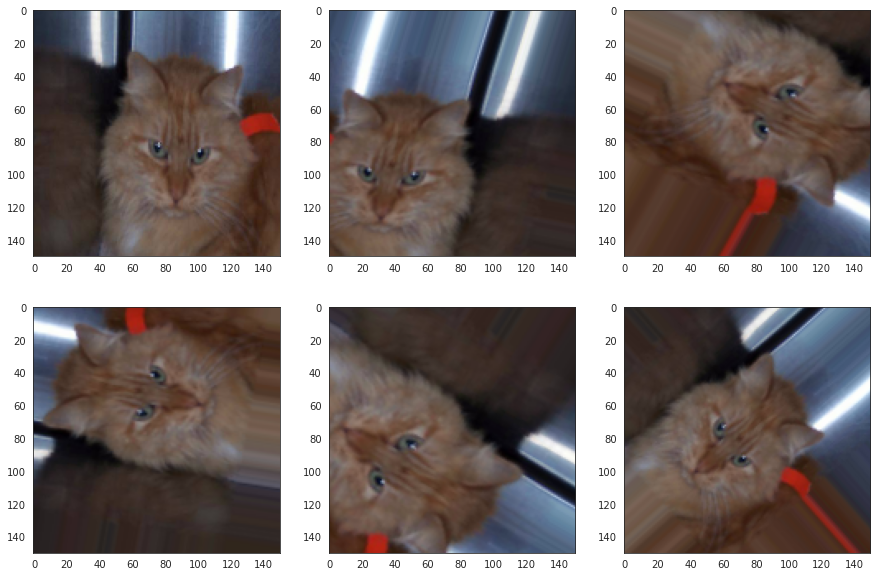

In [46]:
from keras.preprocessing import image
from glob import glob
fnames = glob(os.path.join(train_cats_dir, '*'))

# initialize plot settings
sns.set_style('white') # resets the plotting style
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# test image
img_path = fnames[11]
img = image.load_img(img_path, target_size=(150, 150))
axes[0].imshow(img) # plot original image

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
for index, batch in enumerate(datagen.flow(x, batch_size=1)):
    axes[index+1].imshow(image.array_to_img(batch[0]))
    if index==4:
        break
plt.show()

If you train a new network using this data-augmentation configuration, the network will never see the same input twice (very low probability). But the inputs it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. 

To further fight overfitting, let's also add a Dropout layer to your model, right before the densely connected classifier. Dropout prevents overfitting by preventing a layer's "over-reliance" to some the inputs that are normally biased by order of appearance or duplicity. Since you drop hidden outputs at random, the intuition why 'dropout' improves generalization is that the layer are forced to scan all of its inputs during training. Dropout was introduced by **Srivastava, Hinton *et al*** (first figure of the article shown below), you can find the article [here](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf).

<img src="dropout.png" width="700">

# Defining a new CNN that includes dropout

In [47]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # <--------- DROPOUT
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(learning_rate=1e-4),
metrics=['acc'])

In [48]:
 model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

Let’s train the network using data augmentation in `train_datagen` below and dropout (shown above).

In [49]:
%%time
# augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20, 
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30, # set to 100 for better results
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 28s 274ms/step - loss: 0.6959 - acc: 0.4900 - val_loss: 0.6876 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 27s 272ms/step - loss: 0.6877 - acc: 0.5350 - val_loss: 0.6727 - val_acc: 0.5760
Epoch 3/30
100/100 [==============================] - 28s 279ms/step - loss: 0.6781 - acc: 0.5770 - val_loss: 0.6844 - val_acc: 0.5230
Epoch 4/30
100/100 [==============================] - 27s 271ms/step - loss: 0.6651 - acc: 0.5905 - val_loss: 0.6654 - val_acc: 0.5860
Epoch 5/30
100/100 [==============================] - 28s 280ms/step - loss: 0.6572 - acc: 0.5970 - val_loss: 0.6377 - val_acc: 0.6380
Epoch 6/30
100/100 [==============================] - 27s 266ms/step - loss: 0.6516 - acc: 0.6165 - val_loss: 0.6441 - val_acc: 0.6210
Epoch 7/30
100/100 [==============================] - 28s 282ms/step - loss: 0.6457 - acc: 0.6260 - val_lo

Recording the training / validation loss / accuracy at each epoch using the model.fit method that returns an History callback, which has a history attribute containing the lists of successive losses and other metrics.

### Saving the model

In [50]:
import pickle
# save model
model.save('./models/cats_and_dogs_drop-aug.h5')

# save history
with open('./models/cats_and_dogs_drop-aug_hist.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

And let’s plot the results again. Thanks to data augmentation and dropout, you’re no longer overfitting: the training curves are closely tracking the validation curves. You now reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

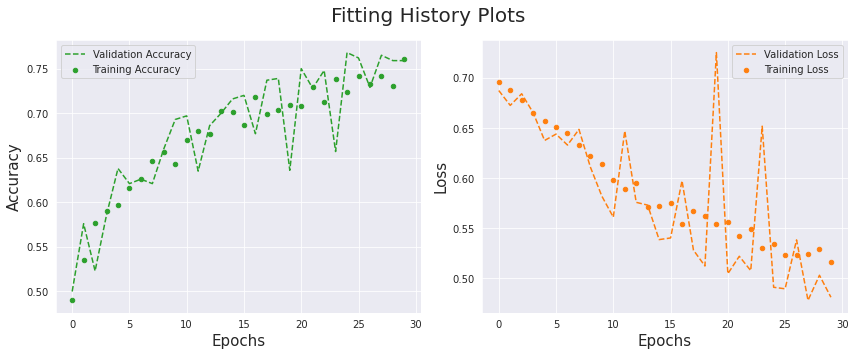

In [61]:
import pickle
with open('./models/cats_and_dogs_drop-aug_hist.pickle', 'rb') as handle:
    hist = pickle.load(handle)
plot_hist(hist)

By using regularization techniques even further, and by tuning the network’s parameters (such as the number of filters per convolution layer, or the number of layers in the network), you may be able to get an even better accuracy, likely up to 86% or 87%. But it would prove difficult to go any higher just by training your own CNN from scratch, because you have so little data to work with. As a next step to improve your accuracy on this problem, you’ll have to use a pretrained model.

**Let's Test it Out on Someone's Pet**

In [52]:
with open('./models/cats_and_dogs_drop-aug_model_architecture.json', 'w') as f:
    f.write(model.to_json())
    
from keras.models import model_from_json
# model reconstruction from JSON file
with open('./models/cats_and_dogs_drop-aug_model_architecture.json', 'r') as f:
    model = model_from_json(f.read())
    
# Load weights into the new model
model.load_weights('./models/cats_and_dogs_drop-aug.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

CAT
[[0.3806388]]


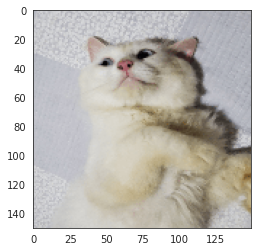

In [53]:
from keras.preprocessing import image
import tensorflow as tf

# img_path = 'images/mycat_charmie.png'
# img_path = 'images/Appa.jpeg'
img_path = 'images/mycat_blue.png'

img = image.load_img(img_path, target_size=(150, 150))
sns.set_style('white')
plt.imshow(img)
x = image.img_to_array(img)

# returns a tensor with a length 1 axis inserted at index axis
# scale values
x = tf.expand_dims(x, axis=0)/255. 

pred = model.predict(x)
if pred >= .5:
    print("DOG")
else:
    print("CAT")
print(pred)

## Another Approach: Softmax and multiclass classification

Alternatively, we can use a `softmax` activation function in the final layer and change the loss function to the `categorical_crossentropy`.

In [54]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(150, 150, 3))

x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(rate=0.5)(x) # <--------- DROPOUT
x = layers.Dense(units=512, activation='relu')(x)

outputs = layers.Dense(units=2, activation='softmax')(x) # <---- SOFTMAX
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0   

In [55]:
# save model architecture
with open('./models/cats_and_dogs_softmax_architecture.json', 'w') as f:
    f.write(model.to_json())

In [56]:
%%time
# compile
model.compile(loss='categorical_crossentropy', # <----- cat crossentropy
optimizer=optimizers.RMSprop(learning_rate=1e-4),
metrics=['acc'])

# augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20, 
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

# fit
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30, # set to 100 for better results
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 28s 276ms/step - loss: 0.6942 - acc: 0.5120 - val_loss: 0.6870 - val_acc: 0.5320
Epoch 2/30
100/100 [==============================] - 28s 276ms/step - loss: 0.6848 - acc: 0.5575 - val_loss: 0.6704 - val_acc: 0.6160
Epoch 3/30
100/100 [==============================] - 28s 278ms/step - loss: 0.6696 - acc: 0.5855 - val_loss: 0.6976 - val_acc: 0.5210
Epoch 4/30
100/100 [==============================] - 28s 278ms/step - loss: 0.6563 - acc: 0.6030 - val_loss: 0.6262 - val_acc: 0.6360
Epoch 5/30
100/100 [==============================] - 27s 274ms/step - loss: 0.6491 - acc: 0.6290 - val_loss: 0.6412 - val_acc: 0.6190
Epoch 6/30
100/100 [==============================] - 28s 280ms/step - loss: 0.6351 - acc: 0.6415 - val_loss: 0.6319 - val_acc: 0.6300
Epoch 7/30
100/100 [==============================] - 27s 271ms/step - loss: 0.6158 - acc: 0.6555 - val_lo

In [57]:
import pickle
# save model
model.save('./models/cats_and_dogs_softmax.h5')

# save history
with open('./models/cats_and_dogs_softmax.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
from keras.models import model_from_json
# model reconstruction from JSON file
with open('./models/cats_and_dogs_softmax_architecture.json', 'r') as f:
    model = model_from_json(f.read())
    
# Load model, we run this after compiling an untrained model
# with the same architechture as above
model.load_weights('./models/cats_and_dogs_softmax.h5')

[[0.52198416 0.47801587]]


array(['cat'], dtype='<U3')

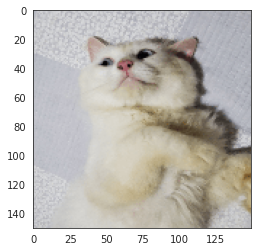

In [59]:
from sklearn.preprocessing import LabelBinarizer
import numpy as np
labels = ['cat', 'dog']
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# img_path = 'images/mycat_charmie.png'
# img_path = 'images/Appa.jpeg'
img_path = 'images/mycat_blue.png'

img = image.load_img(img_path, target_size=(150, 150))
plt.imshow(img)
x = image.img_to_array(img)

# returns a tensor with a length 1 axis inserted at index axis
# scale values
x = tf.expand_dims(x, axis=0)/255. 

pred = model.predict(x)
print(pred)
idxs = np.argsort(pred[0]) # ascending
lb.inverse_transform(idxs[-1]) # get last value (highest score)

## Practice:

You may have noticed that getting the model performance on the `test` set was ommited. This is left as a practice for you. Consider the following:

1. Which functions in `TensorFlow` and `Keras` lend themselves for use in model evaluation on the `test` set?
</br>
</br>
*Next level play* </br>

2. How could applying augmentations at test-time impact the performance on the test set?

3. What is the impact of ensembling the model predictions to the performance? (i.e., averaging the prediction of (i) a model that predicts on un-augmented test set, and (ii) a model that predicts on augmented test set.

## End